# Data Acquisition

:::note

Before continuing with the data acquisition, make sure to satisfy these two conditions.
  
  * OpenBCI firmware version [V3.0.0](https://docs.openbci.com/docs/02Cyton/CytonSDK#firmware-v300-new-commands) is required.
  * Apache Kafka must be running and correctly configured, otherwise is impossible to access to EEG data, check the guide for [configure Kafka](02-kafka_configuration.html#kafka-configuration).
  
:::

## Initialize stream

The main class for acquisition and manipulation of EEG data it's found in [openbci_stream.acquisition](../_modules/openbci_stream.acquisition.cyton.html)

In [10]:
from openbci_stream.acquisition import Cyton
import time

openbci = Cyton('wifi', '192.168.1.78')
# openbci = Cyton('serial', 'COM0')

# stream 15 seconds
openbci.start_stream()
time.sleep(15)  # asynchronous call
openbci.stop_stream()

Buffer size: 3


The above initialize the data streaming, but not capture them, `capture_stream` argument must be configured for access to EEG data.

In [7]:
from openbci_stream.acquisition import Cyton

openbci = Cyton('serial', capture_stream=True)
openbci.stream(15)  # stream 15 second

print(openbci.eeg_time_series)

[[0.06789197 0.05323781 0.1337985  ... 0.23197166 0.33304589 0.30667297]
 [0.23633186 0.27587692 0.04003705 ... 0.35646622 0.05910863 0.10304823]
 [0.17317763 0.23176566 0.01057423 ... 0.12193098 0.18491927 0.26547996]
 ...
 [0.12900776 0.21249815 0.03525203 ... 0.11434788 0.15975804 0.28865859]
 [0.33311875 0.04893903 0.26719506 ... 0.19687683 0.23789245 0.36972269]
 [0.30895978 0.03503397 0.26061421 ... 0.16687564 0.20642643 0.35436994]]


In the first snippet, the stream was activated asynchronously, which means that any task can be implemented between `start_stream` and  `stop_stream`, in the second snippet, the code execution will wait the specified time.

## Datetimes

The `eeg_time_series` object contains a DateTime register, this array can be used to know when the data was recorded.

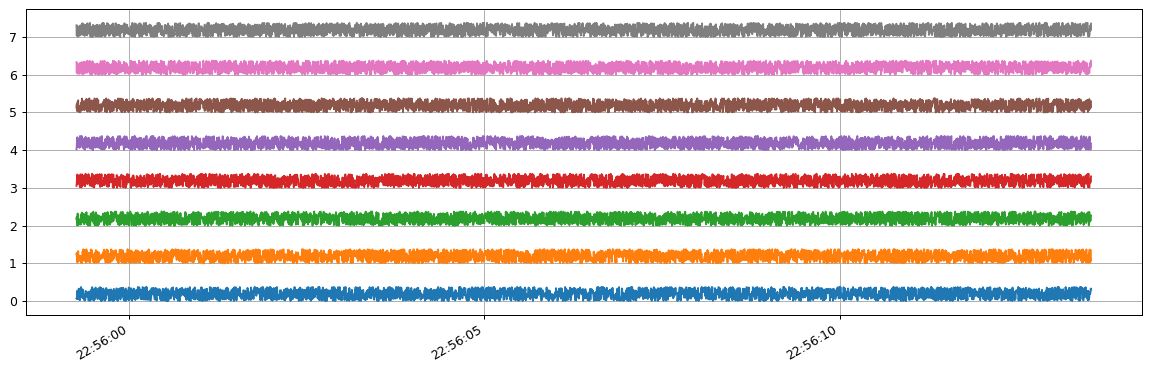

In [22]:
from matplotlib import pyplot as plt
from datetime import datetime

plt.figure(figsize=(16, 5), dpi=90)

time_axis = [datetime.fromtimestamp(_) for _ in openbci.timestamp_time_series]
for i, ch in enumerate(openbci.eeg_time_series):
    plt.plot(time_axis, ch+i)
    
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

## Access to stream

Like the main feature of this package is the distributed data stream, even with `capture_stream=False` is possible to access the data from a different script, process or even another network-attached computer if the data is being transmitted.

In [23]:
from openbci_stream.consumer import OpenBCIConsumer

with OpenBCIConsumer() as stream:
    for i, message in enumerate(stream):
        if message.topic == 'eeg':
            print(f"{i} received {message.value['samples']} samples")
            if i == 9:
                break

0 received 254 samples
1 received 254 samples
2 received 254 samples
3 received 254 samples
4 received 254 samples
5 received 254 samples
6 received 254 samples
7 received 254 samples
8 received 254 samples
9 received 254 samples


`OpenBCIConsumer` has the argument `start`, with this feature is possible to initialize the data acquisition.

In [13]:
from openbci_stream.consumer import OpenBCIConsumer
import time

with OpenBCIConsumer('wifi', '192.168.1.78', stream_samples=500) as (stream, openbci):
    openbci.command(b'SAMPLE_RATE_2KSPS')
    t0 = time.time()
    for i, message in enumerate(stream):
        if message.topic == 'eeg':
            print(f"{i}:{time.time()-t0} received {message.value['samples']} samples")
            t0 = time.time()
            if i == 9:
                break

0:0.8471243381500244 received 514 samples
1:1.9427387714385986 received 504 samples
2:1.8054919242858887 received 499 samples
3:1.8993256092071533 received 502 samples
4:1.755448579788208 received 515 samples
5:0.8504276275634766 received 500 samples
6:0.9608790874481201 received 528 samples
7:0.2647550106048584 received 501 samples
8:1.5101354122161865 received 518 samples
9:2.6500916481018066 received 519 samples


The EEG data is contained in the `message.value` object, with other information about the stream and board configuration.

In [15]:
message.value['data'][0]  # eeg

array([[0.0513152 , 0.22709075, 0.11283865, ..., 0.30472748, 0.27982513,
        0.29301445],
       [0.18755141, 0.03813733, 0.2373561 , ..., 0.06450452, 0.0337428 ,
        0.34428971],
       [0.1814803 , 0.05257403, 0.23128499, ..., 0.19319905, 0.15657795,
        0.06576335],
       ...,
       [0.11260266, 0.03643077, 0.1741261 , ..., 0.36455581, 0.33965347,
        0.19610448],
       [0.25431473, 0.18400222, 0.31876786, ..., 0.03312902, 0.00529698,
        0.22062904],
       [0.12822322, 0.07695368, 0.20732479, ..., 0.02275446, 0.36698706,
        0.18974666]])

## WiFi module

In the same way that `Cyton('serial')` and `OpenBCIConsumer(start='serial')` handle the serial interface, the argument `'wifi'` can be used for a WiFi module.

In [ ]:
Cyton('wifi')
OpenBCIConsumer(start='wifi')

## Daisy

Daisy extension board is detected automatically but can be configured explicitly with the argument `daisy=True`:

In [ ]:
Cyton('serial', daisy=True)
OpenBCIConsumer(start='serial', daisy=True)

## Montage

To define the EEG electrodes position is very useful, this data is streamed too, the argument `montage` receives either a list or a dictionary, this feature, not just register the montage used, but also turn on and off channels on the Cyton board, by default, all channels are turned on.  
A `list` means consecutive channels:

In [ ]:
Cyton('serial', daisy=True, montage=['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'T3', 'C3', 'Cz', 
                                     'C4', 'T4', 'P3', 'Pz', 'P4', 'O1', 'O2', 'Oz'])

A `dictionary` means specific channels:

In [ ]:
Cyton('serial', daisy=True, montage={0: 'Fp1', 1: 'Fp2', 2: 'F3', 3: 'Fz', 4: 'F4'})

## Commands

Cyton boards can be [configured](https://docs.openbci.com/docs/02Cyton/CytonSDK) sending a set of instructions [coded here](../_modules/openbci_stream/acquisition/cyton_base.html#CytonBase).  
All instructions are defined in the main instance.

In [ ]:
openbci.command(openbci.SD_DATA_LOGGING_1HR)
openbci.command(openbci.TEST_1X_SLOW)

This structure is available too.

In [ ]:
openbci.command('SD_DATA_LOGGING_1HR')
openbci.command('TEST_1X_SLOW')

## Differences between *Cyton* and *OpenBCIConsumer*

Both classes allow the board initialization, stream, and data acquisition, `Cyton` can be used in synchronous and asynchronous implementations, is more flexible and the recommended way to handle boards, on the other hand,  `OpenBCIConsumer` is an implementation based in controlled execution, must be used when access immediately to the EEG data is required.